# Mauna Loa CO2 Dataset

atmospheric CO2 concentration data - classic time series with trend and seasonality


In [9]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.experiments import run_exact_proj_svgp
from src.config import TrainCfg, SVGPcfg
from src.kernels import SM_kernel, stable_matern_kernel, stable_rbf_kernel, long_periodic_plus_short_rbf

## Data Preprocessing


loaded 2225 CO2 measurements from 1958-03-29 00:00:00 to 2001-12-29 00:00:00


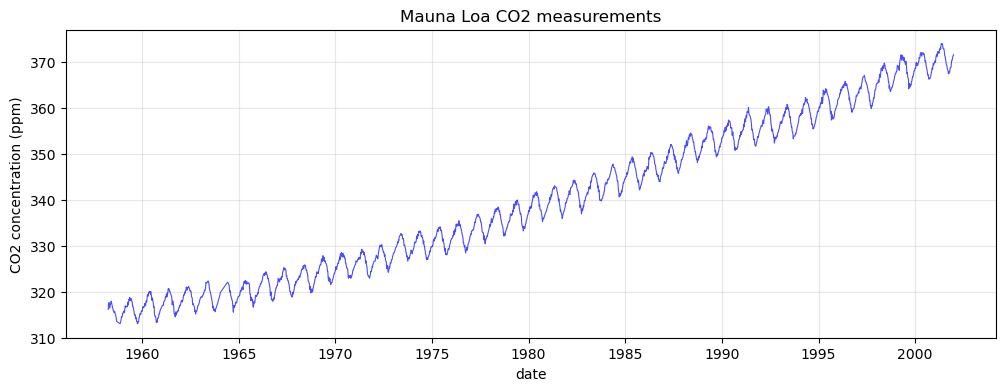

In [2]:
# load and preprocess data
co2 = fetch_openml(data_id=41187, as_frame=True, parser='auto')
df = co2.frame[["year", "month", "day", "co2"]].copy()

# clean and make a pandas datetime
df = df.dropna(subset=["year", "month", "day", "co2"])
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=df["day"]), errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

# filter out sentinel/missing values if present
df = df[df["co2"] > 0].reset_index(drop=True)

print(f"loaded {len(df)} CO2 measurements from {df['date'].min()} to {df['date'].max()}")

# quick plot of raw data
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["co2"], 'b-', alpha=0.7, linewidth=0.8)
plt.xlabel("date")
plt.ylabel("CO2 concentration (ppm)")
plt.title("Mauna Loa CO2 measurements")
plt.grid(alpha=0.3)
plt.show()


In [3]:
# 1D input: time in fractional years from start
t0 = df["date"].min()
x_all = (df["date"] - t0).dt.days.values.astype(np.float32) / 365.25  # years since start
y_all = df["co2"].values.astype(np.float32)

TEST_FRAC = 0.2
rng = np.random.default_rng(0)
perm = rng.permutation(len(x_all))
x_all = x_all[perm]
y_all = y_all[perm]

n = len(x_all)
n_train = int(round((1.0 - TEST_FRAC) * n))
x_train_co2_np = x_all[:n_train]
y_train_co2_np = y_all[:n_train]
x_test_co2_np  = x_all[n_train:]
y_test_co2_np  = y_all[n_train:]

print(f"train points: {len(x_train_co2_np)}, test points: {len(x_test_co2_np)}")

# plot grid across the full span
x_plot_co2 = np.linspace(x_all.min(), x_all.max(), 400).astype(np.float32)


train points: 1780, test points: 445


## GP Regression with Spectral Mixture Kernel - 2 mixtures


running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=15.564735 Delta=inf ||grad||=1.38e+01
noise=0.0981 |raw_noise|grad=0.09967205673456192
[exact] iter=0100 loss=5.343616 Delta=3.72e-02 ||grad||=3.05e+00
noise=0.0954 |raw_noise|grad=0.014109495095908642
[exact] iter=0200 loss=3.947086 Delta=1.95e-02 ||grad||=1.35e+00
noise=0.0966 |raw_noise|grad=0.012767951004207134
[exact] iter=0300 loss=3.134550 Delta=4.08e-02 ||grad||=1.02e+00
noise=0.0972 |raw_noise|grad=0.03349602222442627
[exact] iter=0400 loss=2.869552 Delta=9.22e-03 ||grad||=4.16e-01
noise=0.0933 |raw_noise|grad=0.024980079382658005
[exact] done | time=49.60s best_loss=2.722053

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=2162.093750 Delta=inf ||grad||=3.17e+02
noise=0.1 |raw_noise|grad=10.30048942565918
[proj ] iter=0100 loss=1782.696289 Delta=5.40e+00 ||grad||=2.77e+02
noise=0.12 |raw_noise|grad=8.174751281738281
[proj ] iter=0200 loss

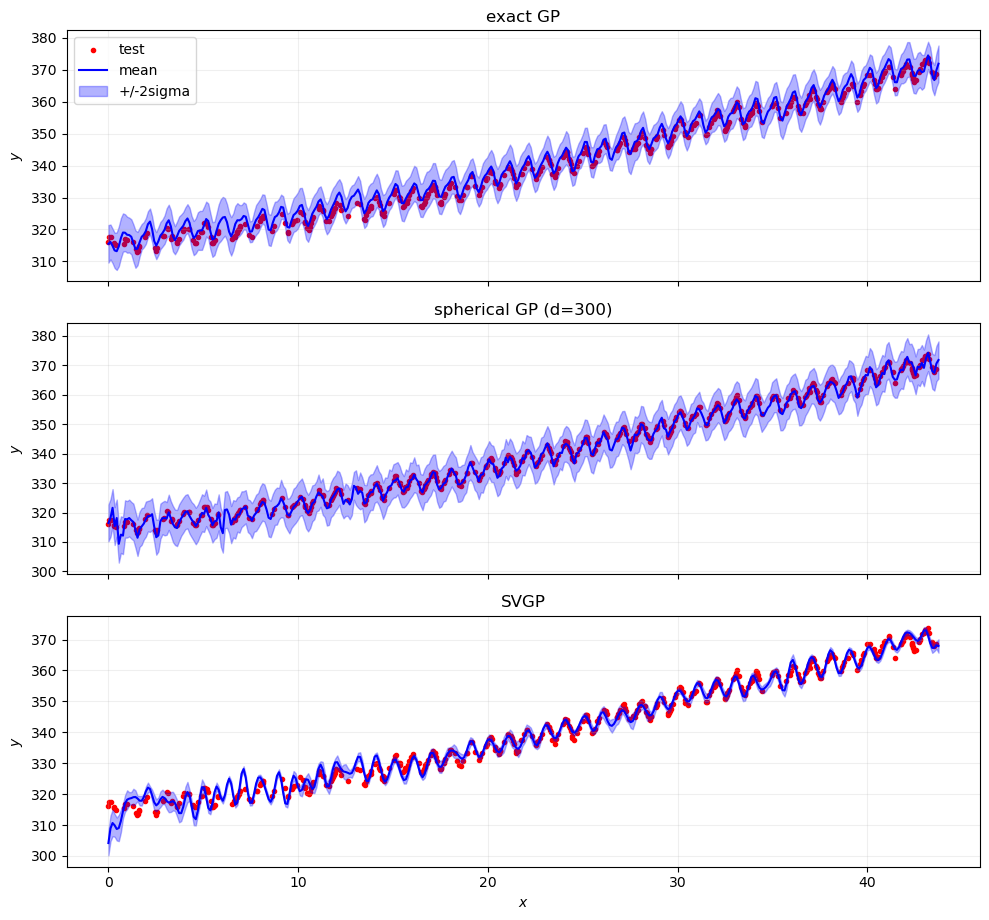

In [11]:
torch.manual_seed(0)
np.random.seed(0)

x_train_co2 = torch.tensor(x_train_co2_np, dtype=torch.float32).unsqueeze(-1)
y_train_co2 = torch.tensor(y_train_co2_np, dtype=torch.float32)
x_test_co2  = torch.tensor(x_test_co2_np,  dtype=torch.float32).unsqueeze(-1)
y_test_co2  = torch.tensor(y_test_co2_np,  dtype=torch.float32)

d_proj = 300
run_exact_proj_svgp(
    x_train_co2, y_train_co2,
    x_test_co2, y_test_co2,
    d_proj=d_proj, num_mixtures=2,
    x_plot=x_plot_co2,
    add_svgp=True, init_hyps_data=False,
    cfg=TrainCfg(upper_noise_constraint=0.1),
    svgp_cfg=SVGPcfg(m_inducing=64),
    savepath='../results/mauna_loa_co2_d300_two_mixtures.png'
)


## GP Regression with RBF Kernel


running exact GP training | iters=500 lr=0.02 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=910.902405 Delta=inf ||grad||=1.19e+03
noise=0.102 |raw_noise|grad=7.8036651611328125
[exact] iter=0100 loss=212.717926 Delta=1.56e+00 ||grad||=1.89e+02
noise=0.448 |raw_noise|grad=3.3568737506866455
[exact] iter=0200 loss=126.303619 Delta=4.86e-01 ||grad||=9.17e+01
noise=0.944 |raw_noise|grad=1.501792311668396
[exact] iter=0300 loss=92.265160 Delta=3.36e-01 ||grad||=5.79e+01
noise=1.41 |raw_noise|grad=0.9055705666542053
[exact] iter=0400 loss=74.170753 Delta=1.45e-01 ||grad||=4.17e+01
noise=1.81 |raw_noise|grad=0.6228294968605042
[exact] done | time=15.19s best_loss=62.621964

running spherical GP training | iters=500 lr=0.02 d=300 jitter=0.0001
[proj ] iter=0000 loss=58275.445312 Delta=inf ||grad||=4.45e+04
noise=0.1 |raw_noise|grad=7163.8984375
[proj ] iter=0100 loss=29302.726562 Delta=1.62e+02 ||grad||=1.49e+04
noise=0.115 |raw_noise|grad=1762.4317626953125
[proj ] iter=0200 loss=18792.96

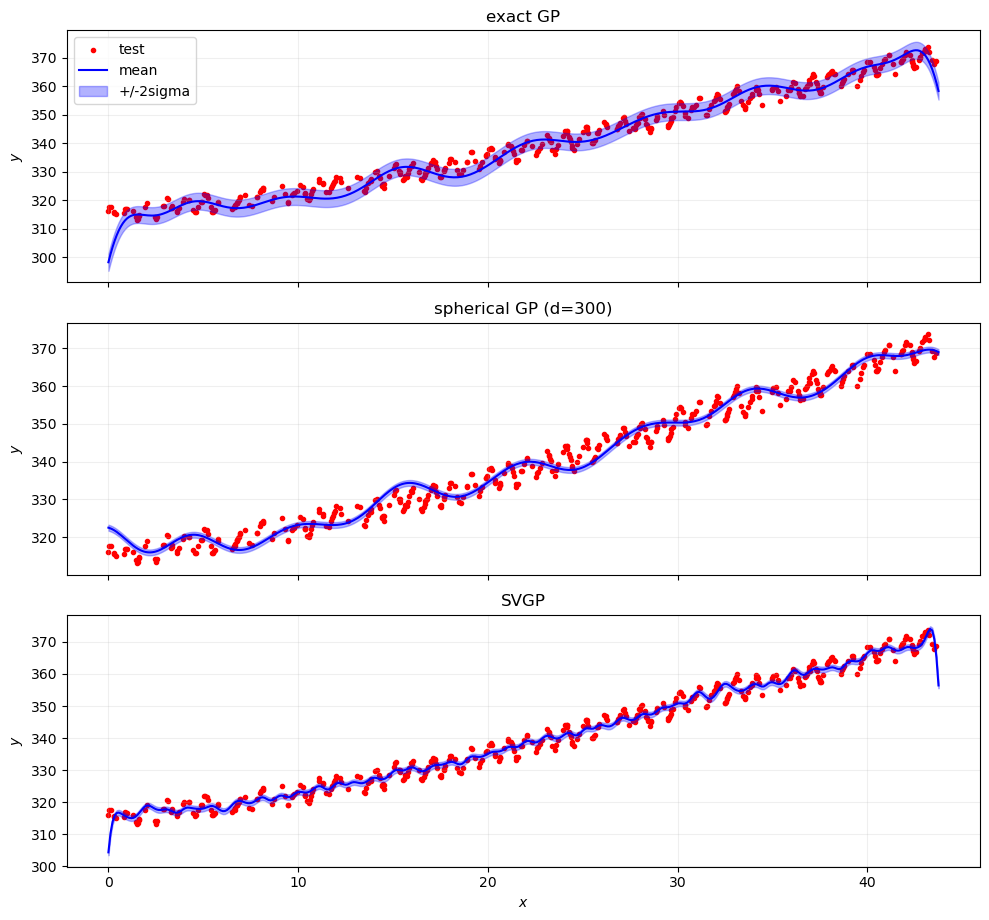

In [6]:
torch.manual_seed(0)
np.random.seed(0)

x_train_co2 = torch.tensor(x_train_co2_np, dtype=torch.float32).unsqueeze(-1)
y_train_co2 = torch.tensor(y_train_co2_np, dtype=torch.float32)
x_test_co2  = torch.tensor(x_test_co2_np,  dtype=torch.float32).unsqueeze(-1)
y_test_co2  = torch.tensor(y_test_co2_np,  dtype=torch.float32)

matern_kernel = stable_matern_kernel(init_lengthscale=1.0, nu=2.5)

d_proj = 300
run_exact_proj_svgp(
    x_train_co2, y_train_co2,
    x_test_co2, y_test_co2,
    d_proj=d_proj, num_mixtures=2,
    kernel_exact=matern_kernel, kernel_proj=matern_kernel, kernel_svgp=matern_kernel,
    x_plot=x_plot_co2,
    add_svgp=True, init_hyps_data=False,
    cfg=TrainCfg(upper_noise_constraint=0.1),
    savepath='../results/mauna_loa_co2_d300_two_mixtures_matern.png'
)


## Testing Different Projection Dimensions


In [ ]:
# test with minimal projection dimension
d_proj = 1
run_exact_proj_svgp(
    x_train_co2, y_train_co2,
    x_test_co2, y_test_co2,
    d_proj=d_proj, num_mixtures=2,
    x_plot=x_plot_co2,
    add_svgp=False, init_hyps_data=False,
    cfg=TrainCfg(upper_noise_constraint=0.1),
    savepath='../results/mauna_loa_co2_d1_minimal_test.png'
)
